# Outback Steakhouse - Sentiment Analysis with BERT


*  WebScraping 
* BeautifulSoup 
- SentimentAnalysis 
- NLP 
- BERT


As Indian immigrants living in the Bay Area, believe it or not, Outback Steakhouse has become our go-to spot for a good meal. When we decide to dine out, we rely on online reviews like our survival guide, making sure to pick places with at least four stars. But guess what? Our accidental discovery of Outback shattered all our expectations.

Now, my husband and I have developed a monthly ritual of indulging in a good meal at this cozy joint. We've even been to other highly-rated restaurants that left us feeling like we made a huge mistake. It's funny how subjective online reviews can be! We always find ourselves wondering why Outback, with its pretty darn good food compared to the rest, doesn't have higher ratings.

Well, guess what? I've taken it upon myself to unravel this mystery once and for all! Time to find out why Outback doesn't get the love it truly deserves. 

Let the investigation begin!

## Import Libraries

We are going to scrape customer reviews from Yelp and use the BERT model for the sentiment analysis.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('ggplot')

import nltk
from nltk import ngrams

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

## Using the Bert model

In [12]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

## Collect Reviews

Let us scrape the reviews from Outback's Yelp page and load it into a dataframe

In [5]:
r = requests.get('https://www.yelp.com/biz/outback-steakhouse-milpitas#reviews')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

base_url = 'https://www.yelp.com/biz/outback-steakhouse-milpitas'
page = 10
while True:
    url = f'{base_url}?start={page}#reviews'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    regex = re.compile('.*comment.*')
    results = soup.find_all('p', {'class': regex})
    
    if not results:
        # No more reviews found, break out of the loop
        break
    
    reviews.extend([result.text for result in results])
    page += 10

df = pd.DataFrame(np.array(reviews), columns=['review'])
df.shape

(984, 1)

## Sentimental Analysis

Let's create a function to do sentiment analysis and apply the function on each review in the dataframe

In [13]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1


In [16]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))



Let us remove the comments from Outback team in response to the customer reviews.

In [53]:
filtered_df = df[~df['review'].str.contains('Sincerely', case=False, na=False) 
                 & ~df['review'].str.contains('We would like to get in contact with you directly', case=False, na=False)
                 & ~df['review'].str.contains('Please take a moment to message us with your email', case=False, na=False) 
                 & ~df['review'].str.contains(r'Thank you.+Outback Steakhouse', case=False, na=False, regex=True)
                 & ~df['review'].str.contains(r'Outback Management Team', case=False, na=False, regex=True)
                 & ~df['review'].str.contains(r'Daniel D.Outback Steakhouse', case=False, na=False, regex=True)
                ]
filtered_df.shape


(905, 2)

In [36]:
pd.set_option('display.max_colwidth' , None)
pd.set_option('display.max_rows' , None)

filtered_df.iloc[0:5]

,review,sentiment
0,"The food was delicious, the staff at the bar were nice.... !I called ahead of time per the advertisement to put my name down and arrive in 20 minutes and the lady FLAKED . She said it was 4:30pm and they stop doing the call in's then hung up. We went anyway and I asked the staff manager about the situation and he was sorry this happened because it was not true.Alway get a person's name when speaking to a restaurant staff....Best of luck",1
1,"The service was extremely slow and the food was mediocre.They served our drinks (strawberry kiwi lemonade)20 mins after we've been seated.Ordered 3 items and got our main meal first before the complimentary bread.Received it in this order:Burger - Complimentary bread - Salad - SoupIt should be: Complimentary bread - Salad - Burger & SoupThe Outbacker Burger tasted so bland.This burger had no sauce except ""mustard"" spread on the bottom bun.Cobb Salad was nothing like the traditional Cobb Salad that we know of.Lettuce were unfresh, bacon bits tasted like costco's, eggs all smudged, fully loaded with thick shredded cheddar cheese, bread crumbs were stale! and the ""dressing"" was not even served on the side..it was drenched in dressing as if they were just trying to hide the poor quality.The Chicken Tortilla soup was so lukewarm.It actually tasted just like those chicken & cheese chimichangas by el monterey...Strawberry Kiwi Lemonade didn't have any lemon flavor.We took lemons from our water and manually turned the drink into ""lemonade""The only thing that was delicious was the complimentary bread.(bread was served after our main meal. We couldn't finish the bread..)C'mom Outback??We spent around $50 for this experience.I was so angry to ruin my appetite, waste my time and money at this restaurant.Save your money and go to ""Jollibee"" instead at Great Mall.Fastfood has way better service & food than here!",2
2,"Tried a taster of the Mango Wheat Ale and found it to be very flavorful with a wonderful scent of mango.Classic wings to start, a little salad, and then it is time for the steak.My favorite spot is at the bar. 1. No wait 2. Best service3. The game is onAmbiance is always nice with good music. Even if you show up alone, the bartender with chat it up with you when they check on you. Better yet, bring the crowd!",5
3,"Holiday parking is a nightmare, so consider ordering with the pick up and go option. It is worth it!",4
4,"Thank you for recognizing veterans!Enjoyed the blooming onion with my coke and a shot of Fireball Cinnamon Whisky, yum.",5


## Visualising the Sentiments

In [62]:
grouped_df = filtered_df.groupby('sentiment').count().reset_index()
grouped_df

,sentiment,review
0,1,208
1,2,178
2,3,142
3,4,165
4,5,212


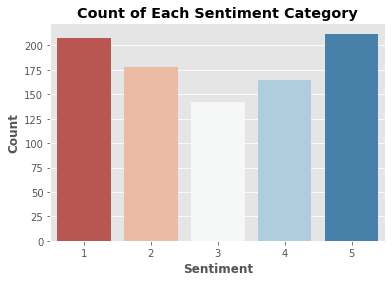

In [63]:
sns.barplot(x=grouped_df['sentiment'], y=grouped_df['review'], palette = 'RdBu')
plt.title('Count of Each Sentiment Category', fontweight = 'bold')
plt.xlabel('Sentiment',fontweight = 'bold')
plt.ylabel('Count',fontweight = 'bold')
plt.show()

## Finding out the problems

Even if we consider the likelihood that dissatisfied customers are more inclined to express their grievances through online reviews, it's intriguing to observe the abundance of negative feedback surrounding Outback. 

We're curious to explore the most common complaints shared by customers and gain insights into their concerns. By delving into these reviews, we can better understand the potential areas where Outback can improve and enhance the overall dining experience.


- Filter the dataframe to only include reviews with a sentiment less than 3.
- Use NLP library to extract the nouns from the reviews.
- Group the nouns by frequency.
- Identify the nouns that appear most frequently.

In [74]:
# Filter the dataframe to only include reviews with a sentiment less than 3.
negative_reviews = filtered_df[filtered_df['sentiment'] < 3]

# Extract the nouns from the reviews.
nouns = []
for review in negative_reviews['review']:
    nouns.extend(nltk.pos_tag(review.split()))

# Group the nouns by frequency.
noun_counts = {}
for noun, tag in nouns:
    if tag == 'NN':
        if noun not in noun_counts:
            noun_counts[noun] = 1
        else:
            noun_counts[noun] += 1

# Identify the nouns that appear most frequently.
most_common_nouns = sorted(noun_counts.items(), key=lambda x: x[1], reverse=True)

print(most_common_nouns)


[('food', 274), ('steak', 144), ('time', 137), ('order', 136), ('service', 134), ('server', 124), ('place', 103), ('waiter', 80), ('table', 77), ('manager', 71), ('experience', 65), ('medium', 64), ('restaurant', 56), ('waitress', 52), ('wait', 45), ('i', 45), ('salad', 44), ('way', 42), ('dinner', 42), ('bar', 39), ('hour', 39), ('meal', 38), ('service.', 38), ('customer', 37), ('location', 37), ('side', 37), ('rib', 36), ('drink', 31), ('shrimp', 29), ('something', 29), ('night', 29), ('onion', 29), ('food.', 29), ('bread', 28), ('thing', 28), ('bill', 27), ('friend', 26), ('hostess', 25), ('one', 25), ('soup', 24), ('it.', 24), ('table.', 24), ('someone', 24), ('meat', 23), ('appetizer', 23), ('everything', 23), ('staff', 22), ('name', 22), ('sauce', 22), ('piece', 22), ('person', 22), ('guy', 22), ('party', 21), ('day', 21), ('kitchen', 21), ('husband', 20), ('time.', 20), ('star', 20), ('nothing', 19), ('anything', 19), ('outback', 19), ("it's", 19), ('bartender', 18), ('minutes.'

Let us visualise the top 15 frequeently occuring nouns

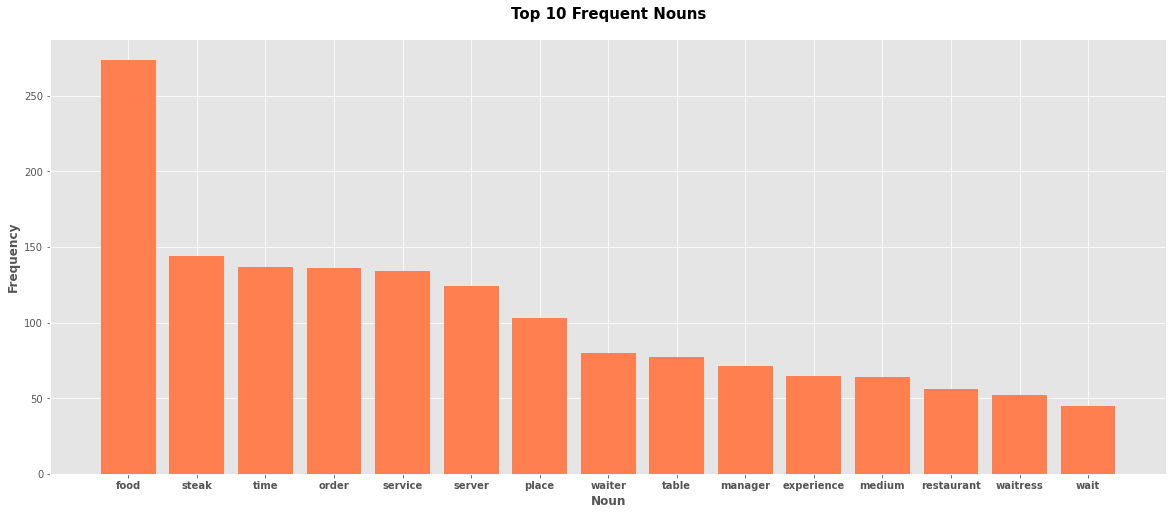

In [93]:
most_common_nouns = sorted(noun_counts.items(), key=lambda x: x[1], reverse=True)[:15]

# Create a bar graph.
plt.figure(figsize = (20,8))
plt.bar(range(len(most_common_nouns)), [x[1] for x in most_common_nouns], align='center', color = 'coral')
plt.xticks(range(len(most_common_nouns)), [x[0] for x in most_common_nouns],fontweight = 'bold')
plt.xlabel('Noun',fontweight = 'bold', fontsize = 12)
plt.ylabel('Frequency',fontweight = 'bold', fontsize = 12)
plt.title('Top 10 Frequent Nouns',fontweight = 'bold', fontsize = 15, pad = 20)
plt.show()

Based on the analysis, it appears that a significant number of customers who expressed dissatisfaction had concerns primarily related to the food, particularly the cooking of the steak. It's like Americans and their love affair with perfectly cooked beef!  
Additionally, there were notable complaints regarding the service quality and long wait times, which contributed to customer dissatisfaction.